In [1]:
%load_ext autoreload
%autoreload 2
%cd C:\MAD4AG
%matplotlib inline

C:\MAD4AG


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import warnings

warnings.filterwarnings('ignore')

In [3]:
file_name = f'./dbs/intermediate/stops.parquet'

#Read each batchs file
df = pd.read_parquet(file_name)

In [4]:
print('The number of stops: ',len(df))
df = df[df.holiday_s != 1]
df = df[df.weekday_s == 1]
df = df.drop(['holiday_s', 'weekday_s'], axis=1)

print('The number of stops in weekday and non-holiday: ', len(df))

The number of stops:  29006512
The number of stops in weekday and non-holiday:  13453097


In [5]:
df_h = pd.read_parquet(f'./dbs/intermediate/home_inference.parquet')
df_h.drop_duplicates(subset='uid', keep='first', inplace=True)

In [6]:
aaa = df.head(1000)

In [6]:
df_1 = pd.merge(df, df_h[['uid','cluster','score']], on= ['uid','cluster'], how="left")
df_1 = df_1[df_1.score.isnull()]
df_1.drop(columns=['score'], inplace=True)

In [7]:
df_2 = df_1[['uid','cluster','Deso','cluster_lat','cluster_lng']]
df_2.drop_duplicates(['uid','cluster'], inplace=True)

In [8]:
building_point = pd.read_parquet(f'./dbs/intermediate/building_point.parquet')

In [9]:
from sklearn.neighbors import BallTree


def building_query_radius(clusters, buildings):
    candidates =  np.radians(buildings[['lat', 'lng']].values)
    src_points = np.radians(clusters[['cluster_lat', 'cluster_lng']].values)

    tree = BallTree(candidates, leaf_size=15, metric='haversine')
    kms_per_radian = 6371.0088

    # define epsilon as 0.1 kilometers, converted to radians for use by haversine
    epsilon = 0.1 / kms_per_radian

    is_within, distances = tree.query_radius(src_points, r=epsilon, count_only=False, return_distance=True)


    return is_within


In [10]:
is_within = building_query_radius(df_2, building_point)


In [11]:
building_metadata = pd.read_csv(f'./dbs/building_purpose_codes.csv', encoding='ISO-8859-1', sep=';')

In [12]:
building_point = pd.merge(building_point, building_metadata[['Code','Purpose of building']] , left_on='ANDAMAL_1', right_on='Code', how='left')

Index(['index', 'TARGET_FID', 'ANDAMAL_1', 'Deso', 'KNKOD', 'POINT_X_sweref99',
       'POINT_Y_sweref99', 'lng', 'lat', 'Code', 'Purpose of building'],
      dtype='object')

In [13]:
building_point.reset_index(inplace=True)

In [14]:
def coppier(data, build):

    #aaa = build['Purpose of building']
    #print(aaa.loc[0])
    #print(data)
    aaa = build[data['building_index']]
    #aaa = build['Purpose of building'][build.index.isin(data)].value_counts(normalize=True)
    #print(data)
    #print(aaa)

    unique, counts = np.unique(aaa, return_counts=True)
    data.loc[unique] = counts

    #data = list(aaa)
    #data = aaa.to_dict()

    return data





In [15]:
building_point = building_point[["Purpose of building"]]

In [16]:
Purpose_of_building = building_point["Purpose of building"].unique().tolist()

In [17]:
building_point1 = building_point.to_numpy()

In [18]:
building_point1[0]

array(['Residential'], dtype=object)

In [19]:
df_building_index = pd.DataFrame(is_within, columns=['building_index'])

In [20]:
df_building_index[Purpose_of_building]=0

In [232]:
#df_building_index = df_building_index.loc[:10000]

In [215]:
#df_building_index = df_building_index.apply(lambda x: coppier(x, building_point1), axis=1)

In [21]:
df_split = np.array_split(df_building_index, 20)

for i in range(0,20):
    df_split[i] = df_split[i].apply(lambda x: coppier(x, building_point1), axis=1)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [146]:
df_3 = pd.concat([df_2.reset_index(), df_building_index], ignore_index=True, axis=1)

In [147]:

df_3 = df_3.rename(columns={0:'index_', 1:'uid', 2:'cluster', 3:'Deso', 4:'cluster_lat', 5:'cluster_lng', 6:'building_index'})

In [ ]:
tqdm.pandas()
df = df_3.groupby('Deso').progress_apply(add_individual_clusters)

In [69]:
#df_building_index['building_index1'] = df_building_index['building_index'].values.tolist()

In [154]:
aaa = df_building_index.loc[5]['building_index']
aaa

array([2908963, 2941575, 2772927, 2929742, 2889909, 2890560, 2929743,
       2890111, 2889450, 2889908, 2889460, 2890153], dtype=int64)

In [174]:
ccc = building_point1[aaa]

In [175]:
unique, counts = np.unique(ccc, return_counts=True)

In [196]:
df_building_index.loc[1,unique] = counts

In [75]:
building_point_A['Purpose of building'][building_point_A.index.isin(aaa)].value_counts(normalize=True)

Industrial     0.666667
Activity       0.166667
Residential    0.166667
Name: Purpose of building, dtype: float64

,index,TARGET_FID,ANDAMAL_1,Deso,KNKOD,POINT_X_sweref99,POINT_Y_sweref99,lng,lat
2614204,5956284,5956285,499,1284C1040,1284,348849.8620,6.228315e+06,12.565130,56.175804
2776623,6320305,6320306,319,1284C1040,1284,348846.1394,6.228299e+06,12.565079,56.175661
2776624,6320306,6320307,317,1284C1040,1284,348879.4521,6.228332e+06,12.565597,56.175964
2869531,6554485,6554486,133,1284C1040,1284,348874.3626,6.228242e+06,12.565566,56.175155
2869629,6554694,6554695,133,1284C1040,1284,348846.2646,6.228261e+06,12.565103,56.175318
2869728,6554876,6554877,317,1284C1040,1284,348885.9025,6.228344e+06,12.565694,56.176072
2869780,6554981,6554982,133,1284C1040,1284,348844.6520,6.228231e+06,12.565094,56.175048
2869833,6555108,6555109,133,1284C1040,1284,348862.8500,6.228217e+06,12.565395,56.174926
2870630,6556783,6556784,133,1284C1040,1284,348869.3979,6.228261e+06,12.565476,56.175324
2870782,6557256,6557257,799,1284C1040,1284,348829.7309,6.228261e+06,12.564837,56.175313


[2598417 2596775 2598640 2593122 2598376 2596975 2594436 2592826 2592917
 2598694 2598680 2593820 2596381 2594856 2594895 2596422 2597039 2594299
 2597237 2596827]
[2597221 2597477 2595269 2597619 2595016 2595025 2597272 2594030 2814481
 2838896 2797577 2838897 2814480 2838898 2797578]
[2985781 2988788 2986831 2992522 2990945 2987988 2991641 2985780 2992131
 2992996 2989553 2986268 2992363 2988584 2986712 2994050 2988612 2994039
 2992993 2986736 2989358 2987677 2994038 2988272 2988224 2988970 2986877]
[2987638 2992934 2992997 2989503 2991728 2986072 2988360 2988473 2990068
 2987895 2987804 2991657 2989105 2989106]
[2601535 2601004 2871333 2604536 2598833 2603963 2599912 2600614 2604345
 2599351 2796506 2604333 2604173]
[2993447 2990935 2992502 2990138 2990326 2990936 2992276]
[2594973 2598433 2595759 2595395 2598674 2598298 2592822 2596581 2598738
 2596518 2593754 2598021 2597533 2595196 2598151 2593875 2592983 2596291
 2597887 2598614 2596058]
[2695901 2696115 2688669 2692296 2697669 

In [17]:
src_points = df_2[['cluster_lat', 'cluster_lng']].values
src_points = np.radians(src_points)


In [18]:


candidates =  np.radians(building_point[['lat', 'lng']].values)

In [29]:
from sklearn.neighbors import BallTree

tree = BallTree(candidates, leaf_size=15, metric='haversine')
kms_per_radian = 6371.0088

# define epsilon as 0.1 kilometers, converted to radians for use by haversine
epsilon = 0.1 / kms_per_radian

is_within, distances = tree.query_radius(src_points[:10000], r=epsilon, count_only=False, return_distance=True)

In [11]:
is_within = building_query_radius(df_2, building_point)

In [14]:
aaa = is_within[0]

In [15]:
building_point[aaa]

KeyError: "None of [Int64Index([2870782, 2949938, 2776623, 2869780, 2869629, 2614204, 2869833,\n            2870630, 2869531, 2776624, 2869728, 2870954, 2871059, 2871025,\n            2871005, 2870983],\n           dtype='int64')] are in the [columns]"

In [51]:

# Transpose to get distances and indices into arrays
distances = distances.transpose()
indices = indices.transpose()

# Get closest indices and distances (i.e. array at index 0)
# note: for the second closest points, you would take index 1, etc.
closest = indices[0]
closest_dist = distances[0]


NameError: name 'distances' is not defined

In [ ]:
def add_individual_clusters(data):
    # represent points consistently as (lat, lon)
    coords = data[['lat', 'lng']].values

    # define the number of kilometers in one radian
    kms_per_radian = 6371.0088

    # define epsilon as 0.1 kilometers, converted to radians for use by haversine
    epsilon = 0.1 / kms_per_radian

    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    data['cluster'] = cluster_labels + 1
    return data


<AxesSubplot:>

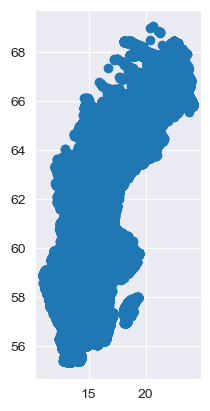

In [13]:
from sklearn.neighbors import BallTree

tree = BallTree(candidates, leaf_size=15, metric='haversine')

In [20]:
kms_per_radian = 6371.0088

# define epsilon as 0.1 kilometers, converted to radians for use by haversine
epsilon = 0.1 / kms_per_radian

is_within, distances = tree.query_radius(src_points[:100], r=epsilon, count_only=False, return_distance=True)


In [18]:
distances_in_km = distances * kms_per_radian


In [21]:
is_within[0]

array([2870782, 2949938, 2776623, 2869780, 2869629, 2614204, 2869833,
       2870630, 2869531, 2776624, 2869728, 2870954, 2871059, 2871025,
       2871005, 2870983], dtype=int64)

In [19]:
distances_in_km[0]

array([0.05752012, 0.07177059, 0.01625722, 0.08412711, 0.05407633,
       0.        , 0.09897969, 0.05749472, 0.07706616, 0.03389296,
       0.04585177, 0.0418915 , 0.07016792, 0.09707521, 0.07751761,
       0.08271527])